In [1]:
#!pip install -q wot

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wot

# Estimate cell growth rates
Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. We do this using signatures of proliferation and apoptosis computed in Notebook 1. 
Examining the histograms of these signatures reveals a bimodal distribution in proliferation rates.

(array([6.8000e+01, 7.6000e+01, 2.8000e+02, 2.6240e+03, 1.3738e+04,
        3.6521e+04, 5.7982e+04, 5.6723e+04, 3.7099e+04, 1.9997e+04,
        1.1403e+04, 6.7720e+03, 3.9900e+03, 2.2060e+03, 1.0530e+03,
        4.2600e+02, 1.6000e+02, 5.6000e+01, 2.1000e+01, 8.0000e+00]),
 array([-0.619866  , -0.53831304, -0.45676007, -0.3752071 , -0.29365414,
        -0.21210118, -0.13054821, -0.04899524,  0.03255772,  0.11411068,
         0.19566365,  0.27721662,  0.35876958,  0.44032255,  0.52187551,
         0.60342848,  0.68498144,  0.76653441,  0.84808737,  0.92964033,
         1.0111933 ]),
 <a list of 20 Patch objects>)

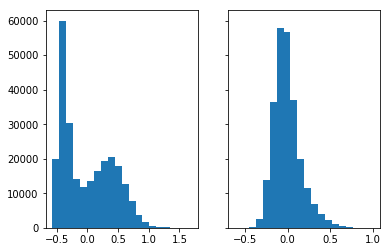

In [15]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# plot histogram of proliferation and apoptosis
fig, axs = plt.subplots(1, 2, sharey=True)
n_bins = 20
axs[0].hist(proliferation, bins=n_bins)
axs[1].hist(apoptosis, bins=n_bins)

We apply a logistic function to transform these two peaks into biologically plausible vaules, in terms of  where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours. 

In [14]:
# apply logistic function to transform to birth rate and death rate

def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)


def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)


def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

def logistic(x, L=1, k=1, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
# g = exp(birth - death)

gr = np.exp(birth-death)
pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr}).to_csv('cell_growth_rates.csv')

# Load data for computing transport maps

We now read in the expression matrix, cell days, initial cell growth rates. 
We apply a filter to compute transport maps for the serum time course. (Recall that the dataset includes two time-courses: 2i and serum). 

In [ ]:
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.loom'
GROWTH_SCORES_PATH = 'data/growth_gs_init.txt'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'

adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, GROWTH_SCORES_PATH], obs_filter=SERUM_CELL_IDS_PATH)

In [2]:
adata.shape

(175472, 1479)

# Compute transport maps

Initialize OT model

In [3]:
ot_model = wot.ot.OTModel(adata, growth_iters=3) 

Compute a single transport map from day 7 to 7.5

In [4]:
tmap_adata = ot_model.compute_transport_map(7,7.5)

The object tmap_adata is an annotated transport matrix. 
The actual transport matrix is tmap_adata.X

tmap_adata.obs encodes the cell barcodes at time t0 and tmap_adata.var encodes the cell barcodes at time t1.

In [5]:
tmap_adata.obs

,g0,g1,g2,g3
id,,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.501791,1.146697,0.898082,0.716976
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.989438,2.519022,2.138183,1.831273
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.699754,1.632620,1.551587,1.464757
D7_Dox_C1_AAACCTGCACTATCTT-1,3.079174,2.796191,2.522095,2.269748
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.014346,0.908840,0.807168,0.713982
D7_Dox_C1_AAACCTGCATATACGC-1,1.245687,1.212256,1.163713,1.107662
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.100886,1.069409,1.025116,0.972374
D7_Dox_C1_AAACCTGTCGGAATCT-1,1.088761,1.155698,1.201569,1.231343
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.416973,0.442949,0.462500,0.476866


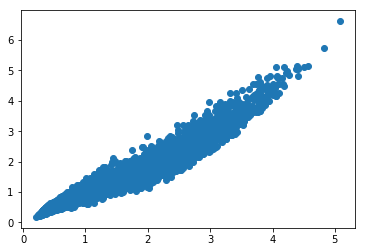

In [6]:
plt.scatter(tmap_adata.obs['g1'],tmap_adata.obs['g2'])
plt.show()

Compute another transport map from day 7.5 to 8

In [ ]:
tmap_adata = ot_model.compute_transport_map(7.5, 8)

Compute all transport maps

In [7]:
ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')